# Stock Price Prediction - Data Exploration & API Evaluation Phase

This notebook focuses on gathering data from multiple sources (Yahoo Finance, FRED, Finnhub, Alpha Vantage) and evaluating API capabilities for technical indicators and real-time validation.

**Current Status**: Data Exploration & API Evaluation

In [ ]:
import os
import time
import json
import requests
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
from dotenv import load_dotenv
import plotly.graph_objects as go
import finnhub

# Load environment variables from .env.local
load_dotenv('.env.local')

FINNHUB_API_KEY = os.getenv('FINNHUB_API_KEY')
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

print("Environment loaded successfully.")

In [ ]:
# UTILITIES: Rate Limiting & Caching

def rate_limited_get(url, delay=12): # 12s sleep = 5 calls/min
    """Prevents hitting Alpha Vantage free tier limits."""
    # Note: Only sleep if calling Alpha Vantage
    if 'alphavantage.co' in url:
        time.sleep(delay)
    return requests.get(url)

def fetch_with_cache(cache_name, fetch_func, *args, **kwargs):
    """Simple local caching to save API calls during exploration."""
    # symbol is usually global from previous cells
    sym = kwargs.get('symbol', 'GLOBAL')
    file_path = f'cache_{cache_name}_{sym}.parquet'
    if os.path.exists(file_path):
        print(f"Loading {cache_name} from cache...")
        return pd.read_parquet(file_path)
    
    data = fetch_func(*args, **kwargs)
    if isinstance(data, pd.DataFrame):
        data.to_parquet(file_path)
        print(f"Saved {cache_name} to cache.")
    return data

### Available Alpha Vantage Indicators
- **Overlays**: SMA, EMA, WMA, DEMA, TEMA, TRIMA, KAMA, MAMA, T3, BBANDS, SAR
- **Momentum**: RSI, STOCH, STOCHF, MACD, ADX, CCI, MOM, ROC, MFI, TRIX, WILLR
- **Volatility**: ATR, NATR, TRANGE
- **Volume**: AD, ADOSC, OBV

In [ ]:
# --- Generalized Data Engineering Layer ---

def get_financial_data(ticker, asset_class='stock', start=None, end=None):
    """
    Fetches market data from heterogeneous sources and normalizes to a standard OHLC DataFrame.
    Supported classes: 'stock', 'forex', 'commodity'
    """
    print(f"Fetching {asset_class} data for: {ticker}...")
    if asset_class == 'stock':
        return yf.download(ticker, start=start, end=end)
    elif asset_class == 'forex':
        # Normalize Forex tickers to yfinance format (e.g., EURUSD=X)
        yf_ticker = ticker.replace('/', '').replace(' ', '')
        if not yf_ticker.endswith('=X'):
            yf_ticker += '=X'
        return yf.download(yf_ticker, start=start, end=end)
    elif asset_class == 'commodity':
        # Handle Gold (GC=F), Silver (SI=F), etc.
        mapping = {'GOLD': 'GC=F', 'XAU': 'GC=F', 'SILVER': 'SI=F', 'XAG': 'SI=F'}
        yf_ticker = mapping.get(ticker.upper(), ticker)
        return yf.download(yf_ticker, start=start, end=end)
    return None

print("Generalized Fetcher initialized.")

## Multi-Asset Exploration (Forex & Gold)
Broadening the pipeline to evaluate predictive patterns in non-stock assets.

In [ ]:
# 1. Forex Exploration: EUR/USD
fx_data = get_financial_data('EUR/USD', asset_class='forex', start='2020-01-01')
if not fx_data.empty:
    print("\n--- EUR/USD Latest Data ---")
    display(fx_data.tail())
    
    # Simple Volatility check
    fx_data['Daily Return'] = fx_data['Close'].pct_change()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fx_data.index, y=fx_data['Close'], name='EUR/USD Close'))
    fig.update_layout(title='EUR/USD Exchange Rate Trend', xaxis_title='Date', yaxis_title='Price')
    fig.show()

In [ ]:
# 2. Commodity Exploration: Gold (XAU)
gold_data = get_financial_data('GOLD', asset_class='commodity', start='2020-01-01')
if not gold_data.empty:
    print("\n--- Gold (Futures) Latest Data ---")
    display(gold_data.tail())
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=gold_data.index, y=gold_data['Close'], name='Gold Price', line=dict(color='orange')))
    fig.update_layout(title='Gold Price (XAU) Trend', xaxis_title='Date', yaxis_title='USD per Ounce')
    fig.show()

| Source                     | API Key     | Historical OHLCV | Frequency      | Good For                  |
| -------------------------- | ----------- | ---------------- | -------------- | ------------------------- |
| Yahoo Finance (`yfinance`) | ❌ No        | Daily            | Daily          | Best general stock data   |
| Stooq                      | ❌ No        | Daily            | Daily          | Global stocks, simple CSV |
| Tiingo                     | ✔ Free      | Daily            | Daily/Intraday | Bonus metadata            |
| IEX Cloud                  | ✔ Free tier | Yes              | Daily          | U.S. stocks               |
| Polygon.io                 | ✔ Free tier | Yes              | Daily/Intraday | More markets              |
| Alpha Vantage              | ✔ Free      | Yes              | Daily/Intraday | Indicators + prices       |
| Finhubb
| Alpha Vantage

In [65]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime

# Define timeframe (aligned with your February 2026 proposal date)
start_date = "2020-01-01"
end_date = "2026-02-01"
symbol = "AAPL" # Example stock

# 1. Fetch Stock Data (Yahoo Finance/Alpha Vantage equivalent)
stock_data = yf.download(symbol, start=start_date, end=end_date)

# 2. Fetch Macroeconomic Data (FRED - Interest Rates)
# Note: 'FEstock_dataUNDS' is the code for the Federal Funds Rate
fred_data = web.DataReader(['FEDFUNDS'], 'fred', start_date, end_date)

# 3. Data Integration Process
# Standardizing frequency and merging
stock_data.columns = stock_data.columns.get_level_values(0)

# Create the target for binary classification (Next-day Up=1, Down=0)
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)


/tmp/ipython-input-4118433774.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [66]:
# Feature Engineering [cite: 136-137]
stock_data['MA 10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA 50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Daily Return'] = stock_data['Close'].pct_change() # Percentage change

# Simple RSI implementation
delta = stock_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

# Cleaning up nulls caused by rolling windows [cite: 79-81]
stock_data.dropna(inplace=True)


In [67]:
# Required for your report structure
print("--- Dataset Structure (stock_data.info) ---")
print(stock_data.info())

print("\n--- Data Preview (stock_data.head) ---")
print(stock_data.head())

print("\n--- Integrity Check (Null Values) ---")
print(stock_data.isnull().sum())


--- Dataset Structure (stock_data.info) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1479 entries, 2020-03-13 to 2026-01-30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1479 non-null   float64
 1   High          1479 non-null   float64
 2   Low           1479 non-null   float64
 3   Open          1479 non-null   float64
 4   Volume        1479 non-null   int64  
 5   Target        1479 non-null   int64  
 6   MA 10         1479 non-null   float64
 7   MA 50         1479 non-null   float64
 8   Daily Return  1479 non-null   float64
 9   RSI           1479 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 127.1 KB
None

--- Data Preview (stock_data.head) ---
Price           Close       High        Low       Open     Volume  Target  \
Date                                                                        
2020-03-13  67.164757  67.635930  61.119275  64.004293  37073200

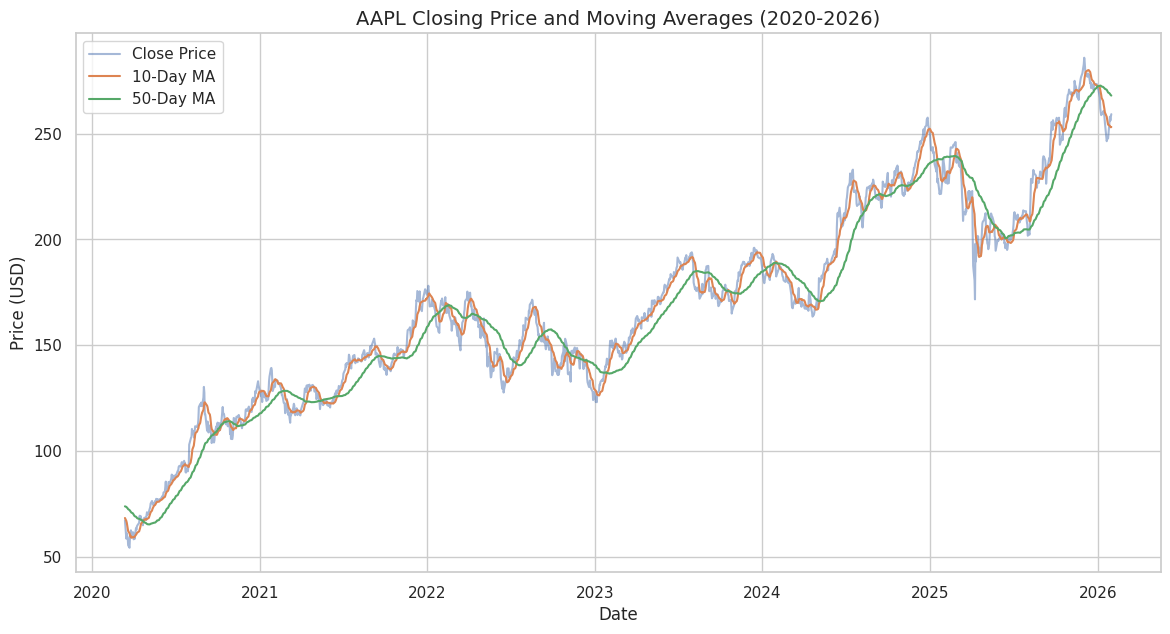

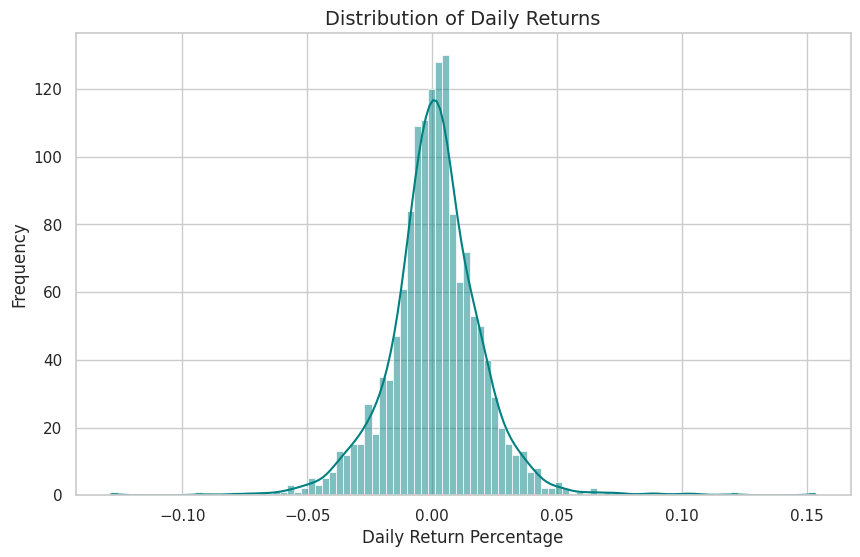

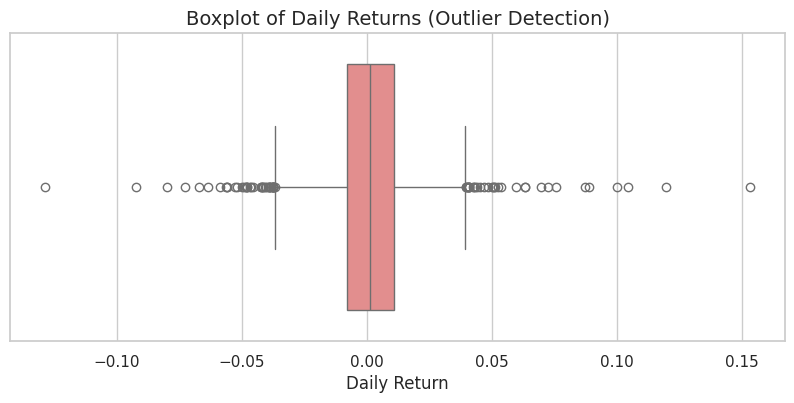

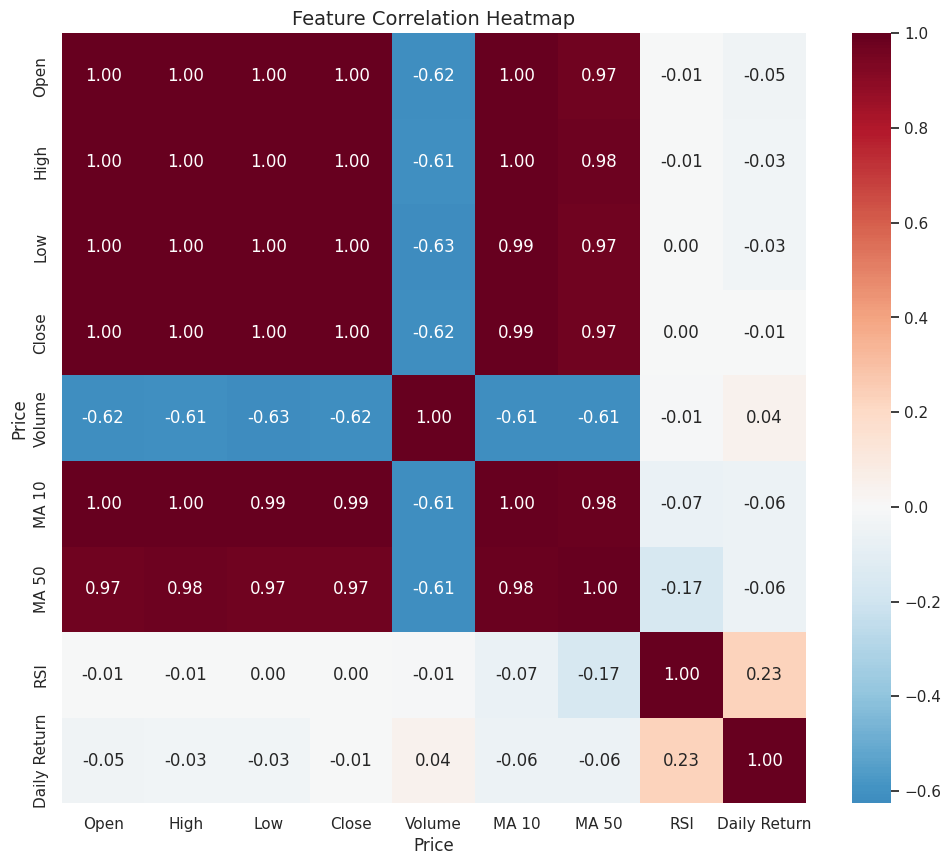

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")

# 1. Time Series Visualization (Closing Price & Moving Averages)
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', alpha=0.5)
plt.plot(stock_data.index, stock_data['MA 10'], label='10-Day MA', linewidth=1.5)
plt.plot(stock_data.index, stock_data['MA 50'], label='50-Day MA', linewidth=1.5)
plt.title('AAPL Closing Price and Moving Averages (2020-2026)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('images/time_series_price.png')

# 2. Distribution of Daily Returns
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['Daily Return'], kde=True, color='teal', bins=100)
plt.title('Distribution of Daily Returns', fontsize=14)
plt.xlabel('Daily Return Percentage')
plt.ylabel('Frequency')
plt.savefig('images/returns_distribution.png')

# 3. Boxplot for Outlier Detection
plt.figure(figsize=(10, 4))
sns.boxplot(x=stock_data['Daily Return'], color='lightcoral')
plt.title('Boxplot of Daily Returns (Outlier Detection)', fontsize=14)
plt.xlabel('Daily Return')
plt.savefig('images/outlier_boxplot.png')

# 4. Correlation Matrix
plt.figure(figsize=(12, 10))
# Selecting numerical columns for correlation
corr_stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA 10', 'MA 50', 'RSI', 'Daily Return']]
sns.heatmap(corr_stock_data.corr(), annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.savefig('images/correlation_heatmap.png')


In [71]:
import finnhub
import requests
import pandas as pd

# 4. Supplementary Stock Market Validation (Finnhub)
finnhub_api_key = FINNHUB_API_KEY
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

try:
    # Fetch real-time quote for validation
    # symbol is already defined as 'AAPL' in previous cells
    quote = finnhub_client.quote(symbol)
    print(f"\n--- Finnhub Real-time Quote for {symbol} ---")
    finnhub_df = pd.DataFrame({
        'Current Price (c)': [quote['c']],
        'High (h)': [quote['h']],
        'Low (l)': [quote['l']],
        'Open (o)': [quote['o']],
        'Previous Close (pc)': [quote['pc']],
        'Timestamp (t)': [pd.Timestamp(quote['t'], unit='s')]
    })
    display(finnhub_df)
except Exception as e:
    print(f"Finnhub API Error: {e}")



--- Finnhub Real-time Quote for AAPL ---


,Current Price (c),High (h),Low (l),Open (o),Previous Close (pc),Timestamp (t)
0,260.58,264.48,260.05,262.6,264.35,2026-02-19 21:00:00


In [72]:
# 5. Cross-verification of Technical Indicators (Alpha Vantage)
print("\n--- Alpha Vantage Technical Analysis (RSI) ---")
av_api_key = ALPHA_VANTAGE_API_KEY
av_url = f'https://www.alphavantage.co/query?function=RSI&symbol={symbol}&interval=daily&time_period=14&series_type=close&apikey={av_api_key}'

try:
    response = rate_limited_get(av_url)
    av_data = response.json()

    # Get the latest RSI values from Alpha Vantage
    if 'Technical Analysis: RSI' in av_data:
        rsi_data = av_data['Technical Analysis: RSI']
        av_rsi_df = pd.DataFrame([
            {'Date': date, 'RSI': float(values['RSI'])}
            for date, values in list(rsi_data.items())[:10]
        ])
        av_rsi_df['Date'] = pd.to_datetime(av_rsi_df['Date'])
        av_rsi_df = av_rsi_df.sort_values('Date', ascending=False).reset_index(drop=True)

        print(f"Alpha Vantage RSI Data for {symbol}:")
        display(av_rsi_df)
    else:
        print("Alpha Vantage data structure unexpected or limit reached.")
        display(av_data)
except Exception as e:
    print(f"Alpha Vantage API Error: {e}")



--- Alpha Vantage Technical Analysis (RSI) ---
Alpha Vantage RSI Data for AAPL:


,Date,RSI
0,2026-02-19,45.4540
1,2026-02-18,49.0843
2,2026-02-17,48.6091
3,2026-02-13,39.5871
4,2026-02-12,44.9724
5,2026-02-11,63.5509
6,2026-02-10,61.6042
7,2026-02-09,63.2237
8,2026-02-06,69.0258
9,2026-02-05,67.1143


In [73]:
# 6. Final Multi-Source Data Summary
print("Multi-Source Integration Summary:")
print(f"- Yahoo Finance: Historical data up to {stock_data.index[-1].date()}")
print("- FRED: Economic indicators included")
print("- Finnhub: Real-time validation available")
print("- Alpha Vantage: Indicator cross-verification enabled")


Multi-Source Integration Summary:
- Yahoo Finance: Historical data up to 2026-01-30
- FRED: Economic indicators included
- Finnhub: Real-time validation available
- Alpha Vantage: Indicator cross-verification enabled


### Finnhub: Historical Data and Indicators

Finnhub provides historical candle data, which can be used to calculate various technical indicators.

In [74]:
# # Fetch historical candle data from Finnhub
# # Unix timestamps are needed for Finnhub historical data
# from datetime import datetime

# start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
# end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())

# finnhub_candles = finnhub_client.stock_candles(symbol, 'D', start_timestamp, end_timestamp)

# # Convert to pandas DataFrame
# if finnhub_candles and 't' in finnhub_candles:
#     finnhub_hist_df = pd.DataFrame({
#         'Date': pd.to_datetime(finnhub_candles['t'], unit='s'),
#         'Open': finnhub_candles['o'],
#         'High': finnhub_candles['h'],
#         'Low': finnhub_candles['l'],
#         'Close': finnhub_candles['c'],
#         'Volume': finnhub_candles['v']
#     })
#     finnhub_hist_df = finnhub_hist_df.set_index('Date').sort_index()
#     print(f"\n--- Finnhub Historical Data for {symbol} ---")
#     display(finnhub_hist_df.head())

#     # Calculate some indicators similar to Yahoo Finance data
#     finnhub_hist_df['MA 10'] = finnhub_hist_df['Close'].rolling(window=10).mean()
#     finnhub_hist_df['Daily Return'] = finnhub_hist_df['Close'].pct_change()
#     print("\n--- Finnhub Historical Data with Calculated Indicators ---")
#     display(finnhub_hist_df.dropna().head())
# else:
#     print(f"No historical data found for {symbol} from Finnhub or an error occurred.")


### Finnhub: Financial News

Fetching financial news related to the stock to observe potential market drivers.

In [75]:
# Fetch company news from Finnhub within the defined date range
# Note: Finnhub free tier often has limitations on the amount of news data accessible.

# Ensure start_date and end_date are in the correct format (YYYY-MM-DD)
news_start_date = start_date
news_end_date = end_date

print(f"\n--- Finnhub Company News for {symbol} from {news_start_date} to {news_end_date} ---")
try:
    company_news = finnhub_client.company_news(symbol, _from=news_start_date, to=news_end_date)
    if company_news:
        news_df = pd.DataFrame(company_news)
        # Convert timestamp to datetime
        news_df['datetime'] = pd.to_datetime(news_df['datetime'], unit='s')
        display(news_df.head())
        print(f"Total news articles found: {len(news_df)}")
    else:
        print("No news articles found for this period.")
except Exception as e:
    print(f"Finnhub News API Error: {e}")



--- Finnhub Company News for AAPL from 2020-01-01 to 2026-02-01 ---


,category,datetime,headline,id,image,related,source,summary,url
0,company,2026-02-01 23:30:07,Advisory Firm Slashes Income Fund by $8.4 Mill...,138327497,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,FLXR is an actively managed ETF providing dive...,https://finnhub.io/api/news?id=8d17e1db46170f1...
1,company,2026-02-01 22:57:46,Westfuller Advisors Doubles Down on Ultra-Shor...,138327500,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,"Focused on ultra-short U.S. Treasury exposure,...",https://finnhub.io/api/news?id=2691624256c266e...
2,company,2026-02-01 22:42:00,Why a $6 Million Credit Fund Bet Makes Sense W...,138327505,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,FS Credit Opportunities Corp. is a closed-end ...,https://finnhub.io/api/news?id=cf0613d2965e2cb...
3,company,2026-02-01 21:26:08,Warren Buffett Said If He Were 30 Starting Ove...,138326853,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,Warren Buffett isn't known for overcomplicatin...,https://finnhub.io/api/news?id=d012ba0fa54f049...
4,company,2026-01-31 14:30:00,The ‘January barometer’ for stocks comes with ...,138323727,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,If the first month of 2026 can be any guide to...,https://finnhub.io/api/news?id=565d093e36ac369...


Total news articles found: 242


### Finnhub: News Sentiment Analysis

Fetching news sentiment data to understand the overall sentiment around the stock.

In [76]:
# Fetch news sentiment for the symbol
print(f"\n--- Finnhub News Sentiment for {symbol} ---")
try:
    news_sentiment_data = finnhub_client.news_sentiment(symbol)
    if news_sentiment_data:
        sentiment_df = pd.DataFrame([news_sentiment_data])
        display(sentiment_df)
    else:
        print("No news sentiment data found.")
except Exception as e:
    print(f"Finnhub News Sentiment API Error: {e}")



--- Finnhub News Sentiment for AAPL ---
Finnhub News Sentiment API Error: FinnhubAPIException(status_code: 403): You don't have access to this resource.


### Alpha Vantage: Historical Data and Indicators

Alpha Vantage also offers extensive historical data (daily, weekly, monthly) and a direct API for many technical indicators.

In [77]:
# Fetch historical daily adjusted data from Alpha Vantage
av_hist_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={av_api_key}'

print(f"\n--- Fetching Alpha Vantage Historical Data for {symbol} ---")
response = rate_limited_get(av_hist_url)
av_hist_data = response.json()

if 'Time Series (Daily)' in av_hist_data:
    av_daily_data = av_hist_data['Time Series (Daily)']
    av_hist_df = pd.DataFrame.from_dict(av_daily_data, orient='index', dtype=float)
    av_hist_df.index = pd.to_datetime(av_hist_df.index)
    av_hist_df = av_hist_df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. adjusted close': 'Adjusted Close',
        '6. volume': 'Volume',
        '7. dividend amount': 'Dividend Amount',
        '8. split coefficient': 'Split Coefficient'
    })
    av_hist_df = av_hist_df.sort_index()
    # Filter by date range
    av_hist_df = av_hist_df[(av_hist_df.index >= start_date) & (av_hist_df.index <= end_date)]

    print(f"\n--- Alpha Vantage Historical Data for {symbol} ---")
    display(av_hist_df.head())

    # Calculate some indicators similar to Yahoo Finance data
    av_hist_df['MA 10'] = av_hist_df['Close'].rolling(window=10).mean()
    av_hist_df['Daily Return'] = av_hist_df['Close'].pct_change()
    print("\n--- Alpha Vantage Historical Data with Calculated Indicators ---")
    display(av_hist_df.dropna().head())
else:
    print("Alpha Vantage historical data structure unexpected or limit reached.")
    display(av_hist_data)

# Example of fetching a technical indicator directly from Alpha Vantage (SMA)
av_sma_url = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=daily&time_period=10&series_type=close&apikey={av_api_key}'
print(f"\n--- Alpha Vantage Technical Indicator (SMA) for {symbol} ---")
response = rate_limited_get(av_sma_url)
av_sma_data = response.json()

if 'Technical Analysis: SMA' in av_sma_data:
    sma_data = av_sma_data['Technical Analysis: SMA']
    av_sma_df = pd.DataFrame([{'Date': date, 'SMA': float(values['SMA'])} for date, values in list(sma_data.items())[:10]])
    av_sma_df['Date'] = pd.to_datetime(av_sma_df['Date'])
    av_sma_df = av_sma_df.sort_values('Date', ascending=False).reset_index(drop=True)
    display(av_sma_df)
else:
    print("Alpha Vantage SMA data structure unexpected or limit reached.")
    display(av_sma_data)



--- Fetching Alpha Vantage Historical Data for AAPL ---
Alpha Vantage historical data structure unexpected or limit reached.


{'Information': 'Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints'}


--- Alpha Vantage Technical Indicator (SMA) for AAPL ---
Alpha Vantage SMA data structure unexpected or limit reached.


{'Information': 'Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints'}

### Consolidated Data Overview

### Alpha Vantage: Intraday Data (Limited Free Tier)

Let's try to fetch recent intraday data. Free tier usually provides a limited amount of recent intraday data (e.g., last 1-2 days).

In [78]:
# Fetch intraday 5-minute interval data from Alpha Vantage
av_intraday_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=compact&apikey={av_api_key}'

print(f"\n--- Fetching Alpha Vantage Intraday Data for {symbol} ---")
try:
    response = rate_limited_get(av_intraday_url)
    av_intraday_data = response.json()

    if 'Time Series (5min)' in av_intraday_data:
        av_intraday_df = pd.DataFrame.from_dict(av_intraday_data['Time Series (5min)'], orient='index', dtype=float)
        av_intraday_df.index = pd.to_datetime(av_intraday_df.index)
        av_intraday_df = av_intraday_df.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. volume': 'Volume'
        }).sort_index(ascending=False)
        print("Alpha Vantage Intraday (5min) Data:")
        display(av_intraday_df.head())
    else:
        print("Alpha Vantage Intraday data structure unexpected or limit reached.")
        display(av_intraday_data)
except Exception as e:
    print(f"Alpha Vantage Intraday API Error: {e}")



--- Fetching Alpha Vantage Intraday Data for AAPL ---
Alpha Vantage Intraday data structure unexpected or limit reached.


{'Information': 'Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints'}

### Alpha Vantage: Company Overview (Fundamental Data)

We can also try to fetch fundamental data, like a company overview, which provides key financial metrics and descriptions.

In [79]:
# Fetch company overview from Alpha Vantage
av_overview_url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={av_api_key}'

print(f"\n--- Fetching Alpha Vantage Company Overview for {symbol} ---")
try:
    response = rate_limited_get(av_overview_url)
    av_overview_data = response.json()

    if av_overview_data and 'Symbol' in av_overview_data:
        overview_df = pd.DataFrame([av_overview_data])
        print("Alpha Vantage Company Overview:")
        display(overview_df.T)
    else:
        print("Alpha Vantage Company Overview data structure unexpected or limit reached.")
        display(av_overview_data)
except Exception as e:
    print(f"Alpha Vantage Company Overview API Error: {e}")



--- Fetching Alpha Vantage Company Overview for AAPL ---
Alpha Vantage Company Overview data structure unexpected or limit reached.


{'Information': 'Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints'}

In [80]:
print("--- Yahoo Finance Historical Stock Data (stock_data) ---")
display(stock_data.head())

print("\n--- FRED Macroeconomic Data (fred_data) ---")
display(fred_data.head())

print("\n--- Finnhub Real-time Quote (finnhub_df) ---")
display(finnhub_df)

print("\n--- Finnhub Company News (news_df) ---")
display(news_df.head())

print("\n--- Alpha Vantage Recent RSI (av_rsi_df) ---")
display(av_rsi_df.head())


--- Yahoo Finance Historical Stock Data (stock_data) ---


Price,Close,High,Low,Open,Volume,Target,MA 10,MA 50,Daily Return,RSI
Date,,,,,,,,,,
2020-03-13,67.164757,67.635930,61.119275,64.004293,370732000,0,68.282515,73.801322,0.119808,45.068574
2020-03-16,58.524220,62.600444,57.990225,58.461394,322423600,1,66.914913,73.523796,-0.128647,40.052949
2020-03-17,61.097530,62.245250,57.603618,59.804830,324056000,0,66.033947,73.311814,0.043970,41.593073
2020-03-18,59.601864,60.406479,57.294336,57.934647,300233600,0,64.679150,73.058493,-0.024480,43.998923
2020-03-19,59.145187,61.092692,58.620860,59.775831,271857200,0,63.515962,72.802835,-0.007662,43.661282



--- FRED Macroeconomic Data (fred_data) ---


,FEDFUNDS
DATE,
2020-01-01,1.55
2020-02-01,1.58
2020-03-01,0.65
2020-04-01,0.05
2020-05-01,0.05



--- Finnhub Real-time Quote (finnhub_df) ---


,Current Price (c),High (h),Low (l),Open (o),Previous Close (pc),Timestamp (t)
0,260.58,264.48,260.05,262.6,264.35,2026-02-19 21:00:00



--- Finnhub Company News (news_df) ---


,category,datetime,headline,id,image,related,source,summary,url
0,company,2026-02-01 23:30:07,Advisory Firm Slashes Income Fund by $8.4 Mill...,138327497,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,FLXR is an actively managed ETF providing dive...,https://finnhub.io/api/news?id=8d17e1db46170f1...
1,company,2026-02-01 22:57:46,Westfuller Advisors Doubles Down on Ultra-Shor...,138327500,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,"Focused on ultra-short U.S. Treasury exposure,...",https://finnhub.io/api/news?id=2691624256c266e...
2,company,2026-02-01 22:42:00,Why a $6 Million Credit Fund Bet Makes Sense W...,138327505,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,FS Credit Opportunities Corp. is a closed-end ...,https://finnhub.io/api/news?id=cf0613d2965e2cb...
3,company,2026-02-01 21:26:08,Warren Buffett Said If He Were 30 Starting Ove...,138326853,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,Warren Buffett isn't known for overcomplicatin...,https://finnhub.io/api/news?id=d012ba0fa54f049...
4,company,2026-01-31 14:30:00,The ‘January barometer’ for stocks comes with ...,138323727,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,AAPL,Yahoo,If the first month of 2026 can be any guide to...,https://finnhub.io/api/news?id=565d093e36ac369...



--- Alpha Vantage Recent RSI (av_rsi_df) ---


,Date,RSI
0,2026-02-19,45.4540
1,2026-02-18,49.0843
2,2026-02-17,48.6091
3,2026-02-13,39.5871
4,2026-02-12,44.9724


#Pull Historical Data from Stooq (No API Key)

In [88]:
ticker = "AAPL"
stooq_url = f"https://stooq.com/q/d/l/?s={ticker.lower()}.us&i=d"

response = requests.get(stooq_url)
stooq_data = pd.read_csv(StringIO(response.text))

stooq_data["Date"] = pd.to_datetime(stooq_data["Date"])
stooq_data = stooq_data.sort_values("Date")

stooq_data["Source"] = "Stooq"

print("Stooq rows:", len(stooq_data))

pd.set_option('display.max_columns', None)
print(stooq_data.head())


Stooq rows: 10443
        Date      Open      High       Low     Close     Volume Source
0 1984-09-07  0.099265  0.100484  0.098067  0.099265   99149603  Stooq
1 1984-09-10  0.099265  0.099570  0.096879  0.098676   76956267  Stooq
2 1984-09-11  0.099570  0.102271  0.099570  0.100484  181467446  Stooq
3 1984-09-12  0.100484  0.101071  0.097458  0.097458  158527291  Stooq
4 1984-09-13  0.102880  0.103173  0.102880  0.102880  246900394  Stooq


In [85]:
# Rename columns to match
stooq_data.rename(columns={
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Volume": "Volume"
}, inplace=True)

# Align Yahoo columns
yf_data = yf_data[["Date", "Open", "High", "Low", "Close", "Volume", "Source"]]
stooq_data = stooq_data[["Date", "Open", "High", "Low", "Close", "Volume", "Source"]]


In [83]:
import yfinance as yf
import pandas as pd
import requests
from io import StringIO

ticker = "AAPL"

# Pull maximum available history
yf_data = yf.download(
    ticker,
    period="max",      # <-- pulls entire available history
    interval="1d",
    auto_adjust=True,
    progress=False
)

yf_data = yf_data.reset_index()
yf_data["Source"] = "Yahoo"

print("Yahoo rows:", len(yf_data))


Yahoo rows: 11388


In [ ]:
# Visual Benchmarking: Calculated RSI vs Alpha Vantage RSI
try:
    fig = go.Figure()
    if 'stock_data' in locals():
        fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['RSI'], name='Calculated RSI (yfinance)'))
    if 'av_rsi_df' in locals():
        fig.add_trace(go.Scatter(x=av_rsi_df['Date'], y=av_rsi_df['RSI'], name='Alpha Vantage RSI'))
    
    fig.update_layout(title=f'Indicator Benchmarking', xaxis_title='Date', yaxis_title='Value')
    fig.show()
except Exception as e:
    print(f"Benchmarking Chart Error: {e}")